In [1]:
import tensorflow as tf 
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
%matplotlib inline 

In [3]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-1))

In [4]:
def plot_3d(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)

In [5]:
def make_3d_data():
    t = np.arange(0,1.5,1e-2)
    var = np.random.rand(*t.shape) * .5
    x = np.cos(t * np.pi) + var
    y = 1.5*np.sin(t * np.pi) + var
    z = -.5 * x + 1.5 * y + 2 * var
    return x, y, z
    
x,y,z = make_3d_data()
plot_3d(x,y,z)

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [6]:
def make_model(lr=1e-3):
    encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
    decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-1))
    return autoencoder

train_data = np.array([x,y,z]).reshape(-1,3)
model = make_model()
history = model.fit(train_data, train_data, epochs=10)

Train on 150 samples
Epoch 1/10
150/150 [==============================] - 0s 2ms/sample - loss: 1.6734
Epoch 2/10
150/150 [==============================] - 0s 225us/sample - loss: 0.9118
Epoch 3/10
150/150 [==============================] - 0s 79us/sample - loss: 0.2963
Epoch 4/10
150/150 [==============================] - 0s 67us/sample - loss: 0.1500
Epoch 5/10
150/150 [==============================] - 0s 184us/sample - loss: 0.1219
Epoch 6/10
150/150 [==============================] - 0s 113us/sample - loss: 0.1059
Epoch 7/10
150/150 [==============================] - 0s 97us/sample - loss: 0.0971
Epoch 8/10
150/150 [==============================] - 0s 168us/sample - loss: 0.0893
Epoch 9/10
150/150 [==============================] - 0s 100us/sample - loss: 0.0863
Epoch 10/10
150/150 [==============================] - 0s 116us/sample - loss: 0.0816


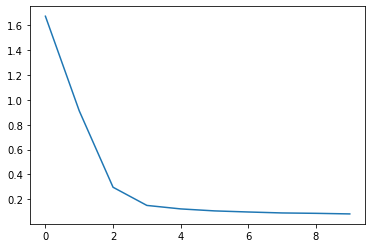

In [7]:
def plot_history(history):
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'])
    plt.show()
    
plot_history(history)

## Encoding Fashion MNIST

In [17]:
def make_autoencoder(lr):
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28,28]),
        keras.layers.Dense(100, activation='selu'),
        keras.layers.Dense(30, activation='selu'),
    ])
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation='selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, activation='sigmoid'),
        keras.layers.Reshape([28,28]),
    ])
    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.RMSprop(lr=lr))
    return stacked_ae

In [18]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [22]:
model = make_autoencoder(1e-3)
hist = model.fit(x_train, x_train, 
                 validation_data=(x_valid, x_valid),
                 batch_size=32, epochs = 3)
os.makedirs('models/17_lecture', exist_ok=True)
model.save('models/17_lecture/mnist-ae-stage-1.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 25s 462us/sample - loss: 0.3137 - val_loss: 0.2985
Epoch 2/3
55000/55000 [==============================] - 28s 503us/sample - loss: 0.2929 - val_loss: 0.2926
Epoch 3/3
55000/55000 [==============================] - 27s 496us/sample - loss: 0.2884 - val_loss: 0.2887


In [24]:
K = keras.backend
model = keras.models.load_model('models/17_lecture/mnist-ae-stage-1.h5')

K.set_value(model.optimizer.lr, 1e-4)
hist = model.fit(x_train, x_train, 
                validation_data = (x_valid, x_valid),
                batch_size=32,
                epochs=4)

model.save('models/17_lecture/mnist-ae-stage-2.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/4
55000/55000 [==============================] - 26s 473us/sample - loss: 0.2836 - val_loss: 0.2853
Epoch 2/4
55000/55000 [==============================] - 33s 595us/sample - loss: 0.2830 - val_loss: 0.2849
Epoch 3/4
55000/55000 [==============================] - 36s 661us/sample - loss: 0.2826 - val_loss: 0.2845
Epoch 4/4
55000/55000 [==============================] - 34s 619us/sample - loss: 0.2823 - val_loss: 0.2841


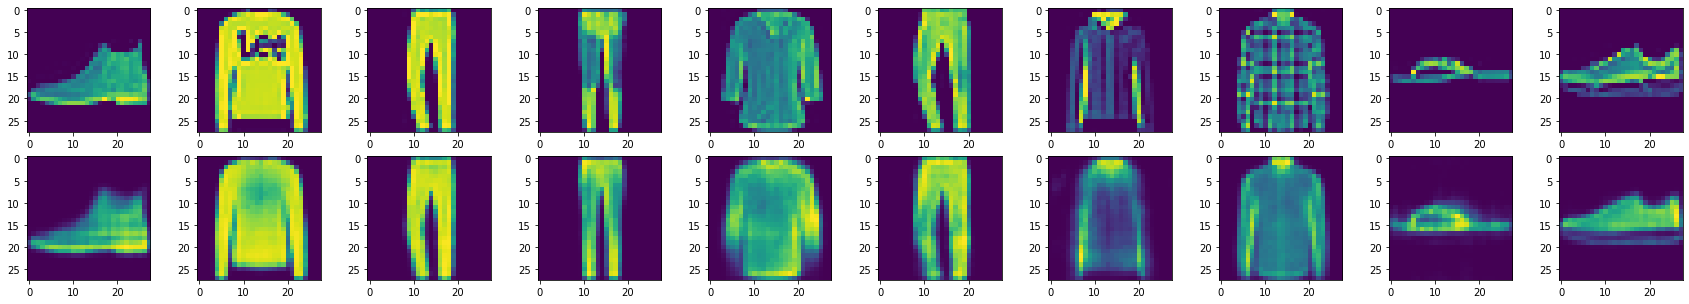

In [26]:
def plot_predictions(model, data, n=5):
    preds = model.predict(data[:n])
    fig,axes = plt.subplots(2,n,figsize=(n*3, 5))
    for img, ax in zip(data,axes[0].ravel()):
        ax.imshow(img)
    for img, ax in zip(preds, axes[1].ravel()):h
        ax.imshow(img)
    plt.show()

plot_predictions(model, x_test, 10)

## Weight tying

In [63]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.bias = self.add_weight(name='bias', initializer='zeros',
                                   shape=[self.dense.input_shape[-1]])
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.bias)

In [65]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer='adam')

In [66]:
hist = tied_ae.fit(x_train, x_train, 
                 validation_data=(x_valid, x_valid),
                 batch_size=32, epochs = 5)
os.makedirs('models/17_lecture', exist_ok=True)
model.save('models/17_lecture/mnist-tied-ae-stage-1.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 25s 453us/sample - loss: 0.3095 - val_loss: 0.2896
Epoch 2/5
55000/55000 [==============================] - 23s 422us/sample - loss: 0.2846 - val_loss: 0.2839
Epoch 3/5
55000/55000 [==============================] - 25s 447us/sample - loss: 0.2811 - val_loss: 0.2817
Epoch 4/5
55000/55000 [==============================] - 24s 443us/sample - loss: 0.2793 - val_loss: 0.2807
Epoch 5/5
55000/55000 [==============================] - 24s 445us/sample - loss: 0.2781 - val_loss: 0.2794


Way better!

## Convolutional Autoencoder

In [104]:
# tf.random.set_seed(42)
# np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer='adam')

In [105]:
hist = conv_ae.fit(x_train, x_train,
                   batch_size=4,
                   validation_data=(x_valid, x_valid),
                   epochs=2,
                  )

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
 1324/55000 [..............................] - ETA: 6:50 - loss: 0.3670

KeyboardInterrupt: 

In [75]:
x_train.shape

(55000, 28, 28)